# Comparing ReMIC-3, ReMIC-2 and ReMIC-1

This notebook compares the images generated with ReMIC-3 (receiving 3 source images) with ReMIC-2 and ReMIC-1. It is based on the notebook `collagan_input_image_comparison.ipynb`, but we're testing the ReMIC models instead of CollaGAN.

In [1]:
import logging_utils

from ModelProxy import RemicModelProxy

logging_utils.configure()

model_loaders = {
    "remic": lambda: RemicModelProxy("models/remic"),
}

2025-06-03 09:20:07.256306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-03 09:20:07.285798: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-03 09:20:07.285847: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-03 09:20:07.305868: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-03 09:20:09.125350: W tensorflow/compiler/tf

## Loads the Larger Dataset

These tests use the Larger dataset.


In [2]:
from dataset_utils import DatasetLoader


dataset_loader = DatasetLoader("all", "test", limit=None)

## Generates Images for a Qualitative Analysis


In [16]:
import tensorflow as tf

print("tf version", tf.__version__)
def generate_batch_with_each_source_combination(number_of_4batches=1, sample_numbers=None):
    mode = "random_batch" if sample_numbers is None else "specific_samples"
    if mode == "random_batch":
        # chooses number_of_4batchs*4 indices of examples to load
        sample_numbers = tf.random.uniform([number_of_4batches*4], minval=0, maxval=dataset_loader.dataset_size, dtype=tf.int32)
        # sample_numbers = tf.sort(sample_numbers)
        print("Sample numbers:", sample_numbers.numpy())
    batch = [dataset_loader.load_paired_images(sample_number) for sample_number in sample_numbers]
    batch = tf.stack(batch, axis=0)
    batch_transpose = batch
    
    genned_images = []    
    target_indices = tf.repeat(tf.range(0, 4), [number_of_4batches] * 4)
    target_images = tf.gather(batch_transpose, target_indices, batch_dims=1)
    # loads the model into memory
    generator = model_loaders["remic"]()
    input_situation_numbers = [1, 2, 3]
    input_situation_names = [f"ReMIC-{n}" for n in input_situation_numbers]
    for situation_name, input_number in zip(input_situation_names, input_situation_numbers):
        # generates the images
        if input_number in [1, 2]:
            # there are 3 images to be generated, in a 2x2 sub-figure
            fake_images = []
            for sample_idx, target_domain in enumerate(target_indices):
                fake_images_of_example = []
                for source_domain in range(4):
                    if source_domain == target_domain:
                        single_fake_image = tf.ones_like(target_images[0])[tf.newaxis, ...] * -1.
                    else:
                        # print("Generating", situation_name, "images for source", source_domain, "and target", target_domain.numpy())
                        if input_number == 1:
                            dropped_mask = tf.constant([1 if i == source_domain else 0 for i in range(4)], dtype=tf.float32)
                            source_images = batch_transpose[sample_idx] * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
                        elif input_number == 2:
                            dropped_mask = tf.constant([0 if i == target_domain or i == source_domain else 1 for i in range(4)], dtype=tf.float32)
                            source_images = batch_transpose[sample_idx] * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
                        # print("...hence, dropped_mask is", dropped_mask.numpy())
                        # print("source_images shape", source_images.shape)
                        # bi = target_domain
                        # print(f"min/max of (source_images[0]) BACK", source_images[0].numpy().min(), source_images[0].numpy().max())
                        # print(f"min/max of (source_images[1]) LEFT", source_images[1].numpy().min(), source_images[1].numpy().max())
                        # print(f"min/max of (source_images[2]) RIGHT", source_images[2].numpy().min(), source_images[2].numpy().max())
                        # print(f"min/max of (source_images[3]) FRONT", source_images[3].numpy().min(), source_images[3].numpy().max())
                        # print("source_images" ,source_images)
                        single_fake_image = generator.generate_from_multiple(
                            target_domain[tf.newaxis, ...], source_images[tf.newaxis, ...])
                    fake_images_of_example += [single_fake_image]
                fake_images_of_example = tf.concat(fake_images_of_example, axis=0)
                fake_images += [fake_images_of_example]
            fake_images = tf.stack(fake_images, axis=0)

        else:
            # there is only one image to be generated, as all source images are used
            dropped_mask = tf.one_hot(target_indices, 4, dtype=tf.float32, off_value=1.0, on_value=0.0)
            source_images = batch_transpose * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]

            fake_images = generator.generate_from_multiple(target_indices, source_images)

        genned_images += [fake_images]
    
    # frees the memory used by the model
    del generator

    # sets the target images in the source images to -1, so it becomes a checkerboard pattern when displaying
    target_in_source_mask = tf.one_hot(target_indices, 4, dtype=tf.float32)[..., tf.newaxis, tf.newaxis, tf.newaxis]
    source_images += target_in_source_mask * -1
    return source_images, target_images, genned_images, ""


starting_test_sample_numbers = stsn = {"tiny": 0, "rm2k": 136, "rmxp": 168, "rmvx": 212, "misc": 273}
example_numbers=[
    stsn["rmxp"]+25,    # rmxp maid lady
    stsn["misc"]+782,   #   
    stsn["rmxp"]+4,     # rmxp bunny tiara girl
    stsn["misc"]+207,
    # stsn["misc"]+1701,  # misc tiny butt
    # stsn["rm2k"]+20,  #
    # stsn["rmxp"]+5,     # rmxp cook
    # stsn["rmvx"]+27,    # rmvx santa
    
    # stsn["rmvx"]+37,    # rmvx fire warlock
    # stsn["misc"]+1304,  # misc crop knight
    # stsn["rmvx"]+27,    # rmvx santa
]
imgs_params = generate_batch_with_each_source_combination(1, example_numbers)


tf version 2.16.2


2025-06-03 13:22:51 INFO     Fingerprint not found. Saved model loading will continue.
2025-06-03 13:22:51 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-06-03 13:22:53 INFO     Fingerprint not found. Saved model loading will continue.
2025-06-03 13:22:53 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-06-03 13:22:56 INFO     Fingerprint not found. Saved model loading will continue.
2025-06-03 13:22:56 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-06-03 13:22:58 INFO     Fingerprint not found. Saved model loading will continue.
2025-06-03 13:22:58 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.
2025-06-03 13:22:59 INFO     Fingerprint not found. Saved model loading will continue.
2025-06-03 13:22:59 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.


Generating ReMIC-1 images for source 1 and target 0
...hence, dropped_mask is [0. 1. 0. 0.]
source_images shape (4, 64, 64, 4)
min/max of (source_images[0]) BACK -0.0 -0.0
min/max of (source_images[1]) LEFT -1.0 1.0
min/max of (source_images[2]) RIGHT -0.0 -0.0
min/max of (source_images[3]) FRONT -0.0 -0.0
Generating ReMIC-1 images for source 2 and target 0
...hence, dropped_mask is [0. 0. 1. 0.]
source_images shape (4, 64, 64, 4)
min/max of (source_images[0]) BACK -0.0 -0.0
min/max of (source_images[1]) LEFT -0.0 -0.0
min/max of (source_images[2]) RIGHT -1.0 1.0
min/max of (source_images[3]) FRONT -0.0 -0.0
Generating ReMIC-1 images for source 3 and target 0
...hence, dropped_mask is [0. 0. 0. 1.]
source_images shape (4, 64, 64, 4)
min/max of (source_images[0]) BACK -0.0 -0.0
min/max of (source_images[1]) LEFT -0.0 -0.0
min/max of (source_images[2]) RIGHT -0.0 -0.0
min/max of (source_images[3]) FRONT -1.0 1.0
Generating ReMIC-1 images for source 0 and target 1
...hence, dropped_mask i

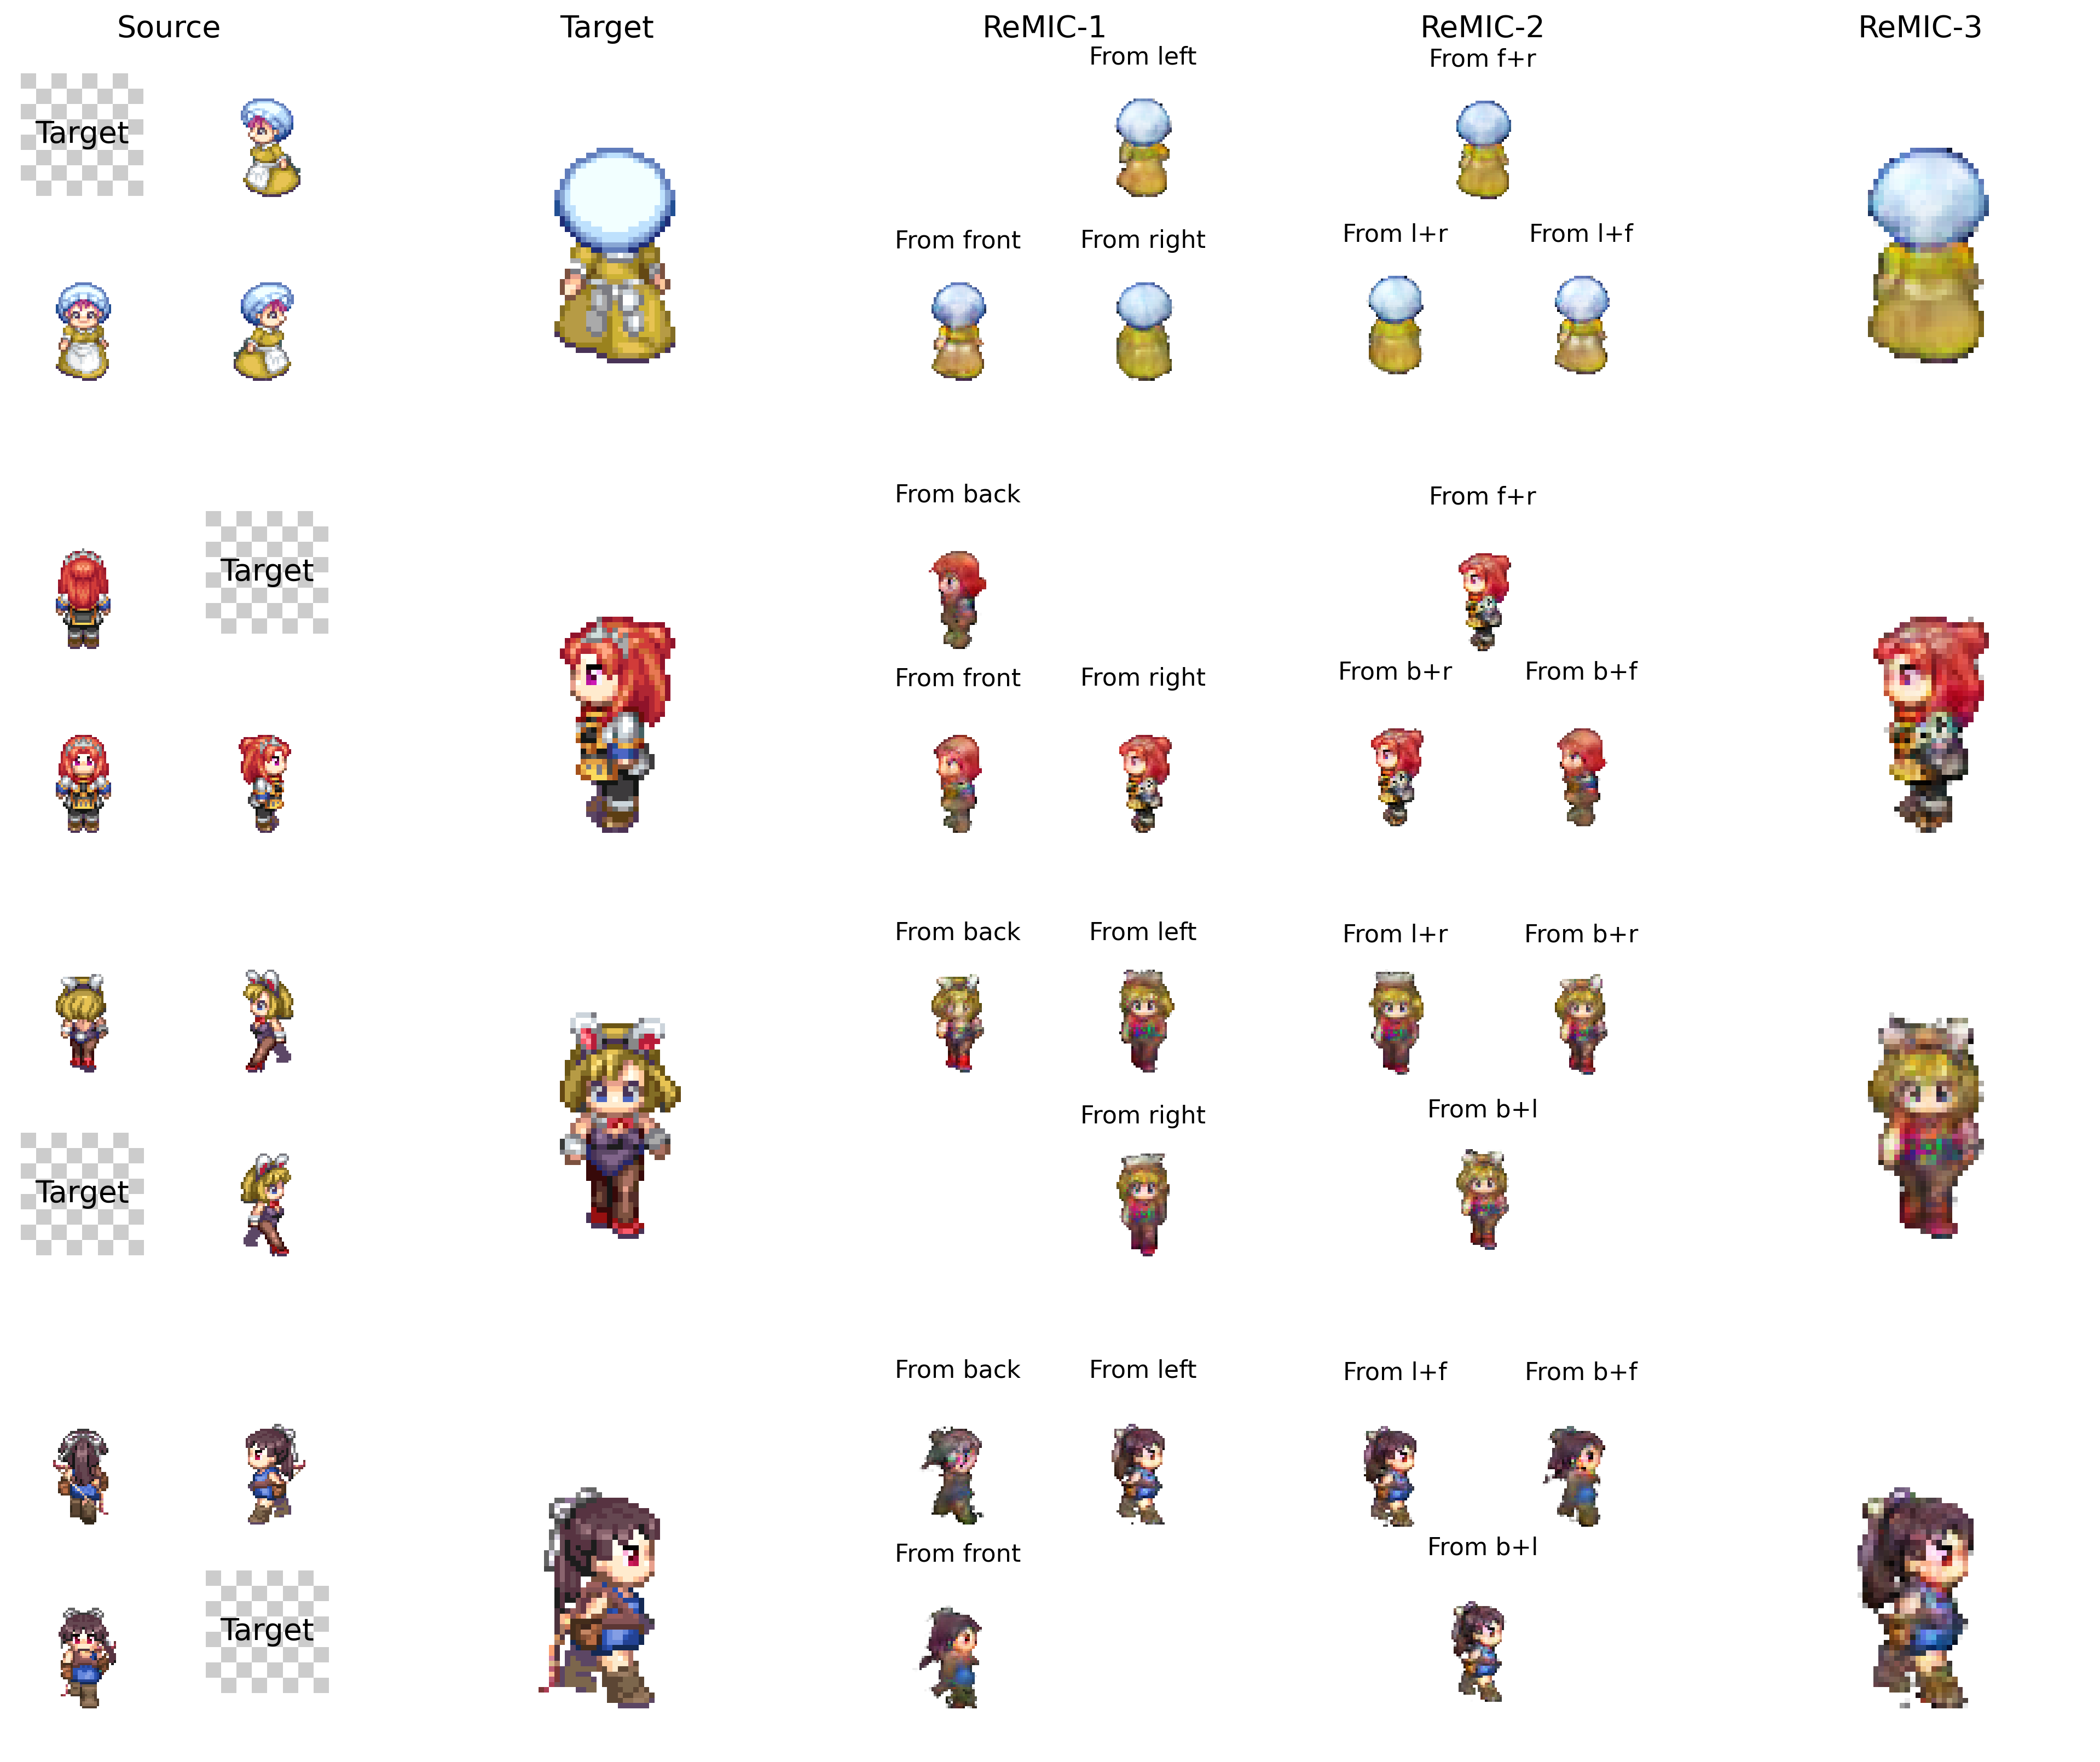

In [6]:
from matplotlib import pyplot as plt
from image_utils import show_collagan_input_comparison


f = show_collagan_input_comparison(*imgs_params, model_names=["ReMIC-1", "ReMIC-2", "ReMIC-3"])
plt.savefig("output/remic_input_comparison.png", format="png", transparent=True)


## Situations where ReMIC-2 might be better than CollaGAN-3

Numerically, the $L_1$ distance for CollaGAN-2 is better than CollaGAN-3 (although FID is not). Let us generate some images to see if there is a qualitative difference.

In [5]:
# import tensorflow as tf
#
#
# def generate_batch_with_each_source_combination(number_of_4batches=1, sample_numbers=None):
#     mode = "random_batch" if sample_numbers is None else "specific_samples"
#     batch_transpose = None
#     if mode == "specific_samples":
#         batch = [dataset_loader.load_paired_images(sample_number) for sample_number in sample_numbers]
#         batch = tf.stack(batch, axis=0)
#         batch_transpose = batch
#     elif mode == "random_batch":
#         # loads a batch of images
#         batch = next(iter(dataset_loader.dataset.shuffle(600).batch(number_of_4batches*4).take(1)))
#         batch_transpose = tf.transpose(batch, [1, 0, 2, 3, 4])
#
#     genned_images = []
#     # left, left, left, left
#     target_indices = tf.repeat([1], [number_of_4batches*4])
#     target_images = tf.gather(batch_transpose, target_indices, batch_dims=1)
#     # loads the model into memory
#     generator = model_loaders["collagan"]()
#     input_situation_names = ["CollaGAN-2 (b+r)", "CollaGAN-2 (f+r)", "CollaGAN-3 (b+f+r)"]
#     for col, situation_name in enumerate(input_situation_names):
#         if col == 0:
#             # CollaGAN-2 b+r (1, 0, 0, 1)
#             dropped_mask = tf.constant([1, 0, 0, 1], dtype=tf.float32)
#         elif col == 1:
#             # CollaGAN-2 f+r (0, 0, 1, 1)
#             dropped_mask = tf.constant([0, 0, 1, 1], dtype=tf.float32)
#         else:
#         # elif col == 2:
#             # CollaGAN-3 b+f+r (1, 0, 1, 1)
#             dropped_mask = tf.constant([1, 0, 1, 1], dtype=tf.float32)
#         source_images = batch_transpose * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
#         fake_images = generator.generate_from_multiple(target_indices, source_images)
#
#         genned_images += [fake_images]
#
#     # frees the memory used by the model
#     del generator
#
#     # sets the target images in the source images to -1, so it becomes a checkerboard pattern when displaying
#     target_in_source_mask = tf.one_hot(target_indices, 4, dtype=tf.float32)[..., tf.newaxis, tf.newaxis, tf.newaxis]
#     source_images += target_in_source_mask * -1
#     return source_images, target_images, genned_images, target_indices, input_situation_names
#
#
# starting_test_sample_numbers = stsn = {"tiny": 0, "rm2k": 136, "rmxp": 168, "rmvx": 212, "misc": 273}
# example_numbers=[
#     stsn["rmxp"]+25,    # rmxp maid lady
#     stsn["misc"]+782,   #
#     stsn["rmxp"]+4,     # rmxp bunny tiara girl
#     stsn["misc"]+207,
#     # stsn["misc"]+1701,  # misc tiny butt
#     # stsn["rm2k"]+20,  #
#     # stsn["rmxp"]+5,     # rmxp cook
#     # stsn["rmvx"]+27,    # rmvx santa
#
#     # stsn["rmvx"]+37,    # rmvx fire warlock
#     # stsn["misc"]+1304,  # misc crop knight
#     # stsn["rmvx"]+27,    # rmvx santa
# ]
# # imgs_params = generate_batch_with_each_source_combination(1, example_numbers)
# imgs_params = generate_batch_with_each_source_combination(1)


2025-05-30 14:17:08.917177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 24 of 600
2025-05-30 14:16:24.164664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-05-30 14:17:29 INFO     Fingerprint not found. Saved model loading will continue.
2025-05-30 14:17:29 INFO     path_and_singleprint metric could not be logged. Saved model loading will continue.


In [ ]:
# from matplotlib import pyplot as plt
# from image_utils import show_comparison
#
#
# f = show_comparison(*imgs_params)
# f.patch.set_alpha(0.0)
# plt.savefig("output/remic2_vs_remic3.png", format="png", transparent=True)


From the visual inspection, we argue that the CollaGAN-3 is still better (FID is lower anyways) because it is crispier and contains more details. The CollaGAN-2 images are blurrier, achieving a lower $L_1$ distance, but they lack details especially regarding the characters" inner edges.